# Tiền xử lý Purchase

In [18]:
# Cell 1 — Import & cấu hình
import pandas as pd
import numpy as np
import json
from pathlib import Path
from joblib import dump
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
# --------------------------
# Config
# --------------------------

LOW_CARD_DEFAULT_THRESHOLD = 20
IQR_FACTOR = 1.5

# Always drop these (system/meta/noise)
DROP_ALWAYS = [
    "is_deleted",
    "created_date",
    "updated_date",
    "event_value",
    "customer_id",
]

OBJ_EXCLUDE = []  # free-text columns (if any)


In [ ]:
# Cell 2 — Đọc dữ liệu parquet, lọc theo pattern và lưu ra file CSV
from pathlib import Path
import pandas as pd

def read_all_parquet(dataset_dir: str, pattern: str = "*.parquet", out_csv: str = "raw_items.csv"):
    dataset = Path(dataset_dir)
    
    # Tìm tất cả các file parquet phù hợp pattern và chứa 'item_chunk'
    all_files = sorted([
        p for p in dataset.rglob("*.parquet")
        if ("history_daily" in p.name.lower() and p.match(pattern))
    ])

    if not all_files:
        raise FileNotFoundError(
            f"No item parquet found in '{dataset_dir}' matching pattern '{pattern}'"
        )

    print(f"Found {len(all_files)} item chunk(s) in '{dataset_dir}'")
    
    # Đọc và gộp các file
    df_raws = [pd.read_parquet(f) for f in all_files]
    combined = pd.concat(df_raws, ignore_index=True)
    print(f"Combined shape: {combined.shape}")

    # Lưu dữ liệu gốc ra CSV để tham khảo
    combined.to_csv(out_csv, index=False)
    print(f"Raw data saved to: {out_csv}")

    return combined

# --- Ví dụ sử dụng ---
input_dir = r"C:\Users\Tin\Downloads\recommendation dataset"
df = read_all_parquet(input_dir, pattern="*.parquet", out_csv="raw_items.csv")


📁 Found 72 item chunk(s) in 'C:\Users\Tin\Downloads\recommendation dataset'
✅ Combined shape: (35729825, 16)
💾 Raw data saved to: raw_items.csv


# Task 1: Loại bỏ các đặc trưng không cần thiết

In [ ]:
# Cell 3 — Task 1: Loại bỏ cột không cần thiết
drop_report = {}

to_drop = [c for c in DROP_ALWAYS if c in df.columns]
if to_drop:
    df = df.drop(columns=to_drop, errors="ignore")
    drop_report["dropped_columns"] = to_drop

print(f"Dropped columns: {to_drop}")
print(f"Remaining columns: {len(df.columns)}")
df.head()


🧹 Dropped columns: ['is_deleted', 'created_date', 'updated_date', 'event_value', 'customer_id']
Remaining columns: 11


,timestamp,user_id,item_id,event_type,price,date_key,quantity,channel,payment,location,discount
0,1735064221,ca12702ddf55acaa9fb767e10faaa67a9b101e06be6ae2...,7115000000004,Purchase,49000.0000,20241224,1,In-Store,VietQR,656,0.0000
1,1735068481,54314ce86269f4849f9a4c3fc85d94b9ba96cbcba64ce1...,0029130000030,Purchase,69000.0000,20241224,1,In-Store,Tiền mặt,143,0.0000
2,1735069843,4799de4022b58689b2b9fb37122479b1ef448d7b7901a9...,3496000000053,Purchase,75000.0000,20241224,2,In-Store,MoMo,213,0.0000
3,1735069779,4799de4022b58689b2b9fb37122479b1ef448d7b7901a9...,2700000000002,Purchase,58500.0000,20241224,2,In-Store,MoMo,213,13000.0000
4,1735379373,3b2423f730815273dfd6f6220b0c5c072d6aab08f9da9b...,0029110000036,Purchase,89000.0000,20241228,1,Android,MoMo,590,10000.0000


# Task 2: Xử lý NULL và Outlier

In [ ]:
# Cell 4 — Task 2: Xử lý NULL và Outlier

def clip_iqr(series: pd.Series, factor: float = 1.5) -> pd.Series:
    if series.isna().all():
        return series
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - factor * iqr, q3 + factor * iqr
    return series.clip(lower, upper)

# Fill missing values
for c in df.select_dtypes(include=["object"]).columns:
    if df[c].isna().any():
        df[c] = df[c].fillna("Unknown")

for c in df.select_dtypes(include=[np.number]).columns:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# Outlier capping
for c in ["price", "discount", "quantity"]:
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
        df[c] = clip_iqr(df[c], factor=IQR_FACTOR)

print("Task 2: NULL and outlier handling done.")
df.describe()


✅ Task 2: NULL and outlier handling done.


,timestamp,date_key,quantity,location
count,3.572982e+07,3.572982e+07,35729825.0,3.572982e+07
mean,1.719940e+09,2.024067e+07,1.0,4.484145e+02
std,9.156783e+06,3.462315e+02,0.0,2.475054e+02
min,1.704091e+09,2.024010e+07,1.0,1.600000e+01
25%,1.711990e+09,2.024040e+07,1.0,2.340000e+02
50%,1.719947e+09,2.024070e+07,1.0,4.390000e+02
75%,1.727899e+09,2.024100e+07,1.0,6.530000e+02
max,1.735685e+09,2.024123e+07,1.0,1.036000e+03


# Task 3: Phân tích tương đồng và loại bỏ đặc trưng thừa

C:\Users\Tin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


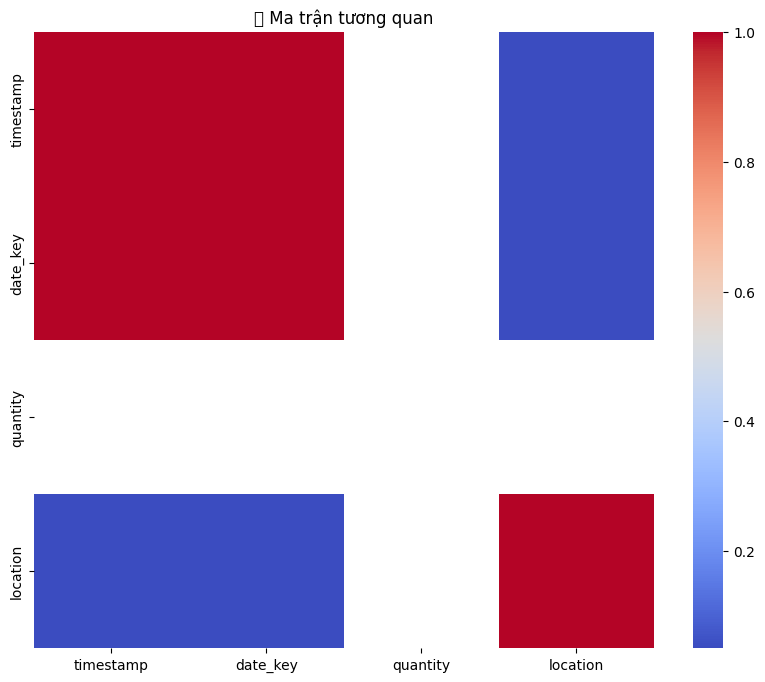

🧩 Removed highly correlated features: {'date_key'}
Remaining columns: 10


In [ ]:
# Cell 5 — Task 3: Phân tích tương quan và loại bỏ đặc trưng thừa
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Ma trận tương quan")
plt.show()

# Loại bỏ đặc trưng tương quan cao (> 0.9)
high_corr = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            colname = corr.columns[i]
            high_corr.add(colname)

if high_corr:
    df = df.drop(columns=list(high_corr), errors="ignore")
    drop_report["high_correlation"] = list(high_corr)

print(f"Removed highly correlated features: {high_corr}")
print(f"Remaining columns: {len(df.columns)}")


# Task 4: Chuẩn hóa dữ liệu

In [ ]:
# Cell 6 — Task 4: Chuẩn hóa dữ liệu (scaling) và mã hóa (encoding)
from sklearn.preprocessing import StandardScaler

def is_id_or_date(c):
    c = c.lower()
    return c.endswith("_id") or "timestamp" in c or "date" in c

num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if not is_id_or_date(c)]
obj_cols = [c for c in df.select_dtypes(include=["object"]).columns if c not in OBJ_EXCLUDE]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# One-hot encoding cho cột ít giá trị
low_card = [c for c in obj_cols if df[c].nunique() <= LOW_CARD_DEFAULT_THRESHOLD]
df = pd.get_dummies(df, columns=low_card, drop_first=True)

print(f"Task 4 done: {len(num_cols)} numeric scaled, {len(low_card)} categorical one-hot encoded.")


✅ Task 4 done: 2 numeric scaled, 3 categorical one-hot encoded.


In [25]:
# Cell 7 — Kiểm tra kết quả sau tất cả bước xử lý
print(f"Final shape: {df.shape}")
print(f"Columns ({len(df.columns)}): {list(df.columns)}")
df.head()


Final shape: (35729825, 26)
Columns (26): ['timestamp', 'user_id', 'item_id', 'price', 'quantity', 'location', 'discount', 'channel_CRM Partner', 'channel_Call', 'channel_Chat', 'channel_In-Store', 'channel_Không xác định', 'channel_SPE', 'channel_TKS', 'channel_Web', 'channel_Wholesale', 'channel_iOS', 'payment_Cà thẻ', 'payment_Không xác định', 'payment_Kredivo', 'payment_MoMo', 'payment_ShopeePay', 'payment_Tiền mặt', 'payment_VNPay', 'payment_VietQR', 'payment_ZaloPay']


,timestamp,user_id,item_id,price,quantity,location,discount,channel_CRM Partner,channel_Call,channel_Chat,...,channel_iOS,payment_Cà thẻ,payment_Không xác định,payment_Kredivo,payment_MoMo,payment_ShopeePay,payment_Tiền mặt,payment_VNPay,payment_VietQR,payment_ZaloPay
0,1735064221,ca12702ddf55acaa9fb767e10faaa67a9b101e06be6ae2...,7115000000004,49000.0000,0.0,0.838711,0.0000,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,1735068481,54314ce86269f4849f9a4c3fc85d94b9ba96cbcba64ce1...,0029130000030,69000.0000,0.0,-1.233971,0.0000,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,1735069843,4799de4022b58689b2b9fb37122479b1ef448d7b7901a9...,3496000000053,75000.0000,0.0,-0.951149,0.0000,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,1735069779,4799de4022b58689b2b9fb37122479b1ef448d7b7901a9...,2700000000002,58500.0000,0.0,-0.951149,13000.0000,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,1735379373,3b2423f730815273dfd6f6220b0c5c072d6aab08f9da9b...,0029110000036,89000.0000,0.0,0.572050,10000.0000,False,False,False,...,False,False,False,False,True,False,False,False,False,False


# Task 5: Rút trích thêm các đặc trưng

| Tên cột mới   | Ý nghĩa              | Mục đích                              |
| ------------- | -------------------- | ------------------------------------- |
| `hour`        | Giờ trong ngày       | Người dùng hay mua vào giờ nào        |
| `day_of_week` | Thứ trong tuần (0-6) | Hành vi mua khác nhau theo ngày       |
| `is_weekend`  | Cuối tuần hay không  | Nhiều người mua hơn cuối tuần         |
| `month`       | Tháng trong năm      | Mùa mua sắm (Tết, Black Friday, etc.) |
| `time_of_day` | Sáng/Chiều/Tối       | Mô hình hành vi theo khung giờ        |


In [ ]:
# Chuyển timestamp về kiểu datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Trích xuất các đặc trưng thời gian
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['month'] = df['timestamp'].dt.month

print("Đặc trưng thời gian được thêm.")
print(f"Shape: {df.shape}")
print(f"Columns ({len(df.columns)}): {list(df.columns)}")


🕒 Đặc trưng thời gian được thêm.
Shape: (35729825, 30)
Columns (30): ['timestamp', 'user_id', 'item_id', 'price', 'quantity', 'location', 'discount', 'channel_CRM Partner', 'channel_Call', 'channel_Chat', 'channel_In-Store', 'channel_Không xác định', 'channel_SPE', 'channel_TKS', 'channel_Web', 'channel_Wholesale', 'channel_iOS', 'payment_Cà thẻ', 'payment_Không xác định', 'payment_Kredivo', 'payment_MoMo', 'payment_ShopeePay', 'payment_Tiền mặt', 'payment_VNPay', 'payment_VietQR', 'payment_ZaloPay', 'hour', 'day_of_week', 'is_weekend', 'month']


| Tên cột mới     | Ý nghĩa                                        |
| --------------- | ---------------------------------------------- |
| `total_value`   | Tổng giá trị mỗi giao dịch: `price * quantity` |
| `discount_rate` | Tỷ lệ giảm giá: `discount / price`             |
| `has_discount`  | Giao dịch có giảm giá không (0/1)              |


In [ ]:
# Tạo các đặc trưng liên quan đến giao dịch
price_n = pd.to_numeric(df.get('price'), errors='coerce').astype(float)
discount_n = pd.to_numeric(df.get('discount'), errors='coerce').astype(float)
quantity_n = pd.to_numeric(df.get('quantity'), errors='coerce').astype(float).fillna(0.0)

df['total_value'] = price_n * quantity_n
# avoid divide-by-zero; set rate to 0 when price is null/zero
discount_rate = pd.Series(0.0, index=df.index)
valid_price_mask = price_n.notna() & (price_n != 0)
discount_rate.loc[valid_price_mask] = (discount_n.loc[valid_price_mask] / price_n.loc[valid_price_mask]).clip(0, 1)
df['discount_rate'] = discount_rate

df['has_discount'] = (discount_n > 0).astype(int)

print("Đặc trưng giá trị đơn hàng được thêm.")
print(f"Shape: {df.shape}")
print(df[['price', 'quantity', 'discount', 'total_value', 'discount_rate', 'has_discount']].head())


💸 Đặc trưng giá trị đơn hàng được thêm.
Shape: (35729825, 33)
        price  quantity    discount  total_value  discount_rate  has_discount
0  49000.0000       0.0      0.0000          0.0       0.000000             0
1  69000.0000       0.0      0.0000          0.0       0.000000             0
2  75000.0000       0.0      0.0000          0.0       0.000000             0
3  58500.0000       0.0  13000.0000          0.0       0.222222             1
4  89000.0000       0.0  10000.0000          0.0       0.112360             1


| Đặc trưng              | Ý nghĩa                     |
| ---------------------- | --------------------------- |
| `user_total_orders`    | Số đơn hàng đã đặt          |
| `user_total_spent`     | Tổng tiền đã chi            |
| `user_avg_order_value` | Giá trị trung bình mỗi đơn  |
| `user_discount_usage`  | Tỷ lệ đơn có giảm giá       |
| `user_channel_pref`    | Kênh mua hàng phổ biến nhất |


In [ ]:
# Tính toán đặc trưng hành vi người dùng
user_features = df.groupby('user_id').agg({
    'total_value': ['sum', 'mean'],
    'has_discount': 'mean',
    'item_id': 'count'
}).reset_index()

# Đặt lại tên cột
user_features.columns = ['user_id', 'user_total_spent', 'user_avg_order_value', 'user_discount_usage', 'user_total_orders']

# Gộp vào DataFrame chính
df = df.merge(user_features, on='user_id', how='left')

print("Đặc trưng hành vi người dùng được thêm.")
print(f"Shape: {df.shape}")
print(df[['user_id', 'user_total_spent', 'user_avg_order_value', 'user_discount_usage', 'user_total_orders']].head())


👤 Đặc trưng hành vi người dùng được thêm.
Shape: (35729825, 37)
                                             user_id  user_total_spent  \
0  ca12702ddf55acaa9fb767e10faaa67a9b101e06be6ae2...               0.0   
1  54314ce86269f4849f9a4c3fc85d94b9ba96cbcba64ce1...               0.0   
2  4799de4022b58689b2b9fb37122479b1ef448d7b7901a9...               0.0   
3  4799de4022b58689b2b9fb37122479b1ef448d7b7901a9...               0.0   
4  3b2423f730815273dfd6f6220b0c5c072d6aab08f9da9b...               0.0   

   user_avg_order_value  user_discount_usage  user_total_orders  
0                   0.0             0.304878                 82  
1                   0.0             0.166667                 12  
2                   0.0             0.300000                 10  
3                   0.0             0.300000                 10  
4                   0.0             0.476744                 86  


In [ ]:
output_path = "enhanced_features.csv"
df.to_csv(output_path, index=False)

print("Task 5 hoàn tất – dữ liệu đã được lưu.")
print(f"Final shape: {df.shape}")
print(f"File saved to: {output_path}")


✅ Task 5 hoàn tất – dữ liệu đã được lưu.
Final shape: (35729825, 45)
File saved to: enhanced_features.csv
